# LSTM

In [8]:
VOCAB_SIZE = 300  # 사용할 단어의 수
SEQ_LEN = 100 # 시퀀스 하나의 최대 길이

### 데이터 준비

In [9]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

In [10]:
import torch

train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input]

train_target = torch.tensor(train_target, dtype=torch.long)
test_target = torch.tensor(test_target, dtype=torch.long)

print(len(train_input), len(test_input))
print(train_target.shape, test_target.shape)

25000 25000
torch.Size([25000]) torch.Size([25000])


In [11]:
train_input, test_input = train_input[:10000], test_input[:5000]
train_target, test_target = train_target[:10000], test_target[:5000]

In [21]:
train_input[0]

tensor([  1,  14,  22,  16,  43,   2,   2,   2,   2,  65,   2,   2,  66,   2,
          4, 173,  36, 256,   5,  25, 100,  43,   2, 112,  50,   2,   2,   9,
         35,   2, 284,   5, 150,   4, 172, 112, 167,   2,   2,   2,  39,   4,
        172,   2,   2,  17,   2,  38,  13,   2,   4, 192,  50,  16,   6, 147,
          2,  19,  14,  22,   4,   2,   2,   2,   4,  22,  71,  87,  12,  16,
         43,   2,  38,  76,  15,  13,   2,   4,  22,  17,   2,  17,  12,  16,
          2,  18,   2,   5,  62,   2,  12,   8,   2,   8, 106,   5,   4,   2,
          2,  16,   2,  66,   2,  33,   4, 130,  12,  16,  38,   2,   5,  25,
        124,  51,  36, 135,  48,  25,   2,  33,   6,  22,  12, 215,  28,  77,
         52,   5,  14,   2,  16,  82,   2,   8,   4, 107, 117,   2,  15, 256,
          4,   2,   7,   2,   5,   2,  36,  71,  43,   2,   2,  26,   2,   2,
         46,   7,   4,   2,   2,  13, 104,  88,   4,   2,  15, 297,  98,  32,
          2,  56,  26, 141,   6, 194,   2,  18,   4, 226,  22,  

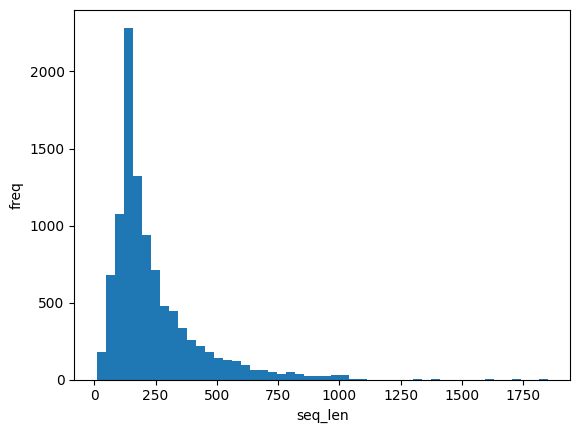

In [12]:
# 입력 데이터 길이 체크
import matplotlib.pyplot as plt
import numpy as np

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=50)
plt.xlabel('seq_len')
plt.ylabel('freq')
plt.show()

In [13]:
# padding 처리
import torch.nn.functional as F

def pad_sequences(sequences, maxlen, padding_value=0):
  padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
  return torch.stack(padded_sequences)  # torch의 단일 tensor로 변환

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

train_seq.shape, test_seq.shape

(torch.Size([10000, 100]), torch.Size([5000, 100]))

In [14]:
# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 100, 300]), torch.Size([5000, 100, 300]))

### 모델 준비 및 학습

##### one-hot encoding + LSTM

In [22]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    _, (hidden, _) = self.lstm(x) # 첫번째 _는 최종출력값 (마지막에 들어가있는 데이터(토큰)의 아웃풋. 이전 정보들만 가지고 오고 싶어서 이렇게 처리를 해줬다)   /  두번째 _는 셀스테이트에 대한 값
    out = self.fc(hidden[-1]) # 최종 출력층을 통과시킴
    return self.sigmoid(out)  # 시그모이드를 통과킨 값을 반환

In [23]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

lstm_model = SentimentLSTM(seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)
print(lstm_model)

SentimentLSTM(
  (lstm): LSTM(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [24]:
total_params = 0
print(f"{'Layer':<20}{'Shape':30}{'Params'}")
print("=" * 60)

for name, param in lstm_model.named_parameters():
  if param.requires_grad: # gradient가 필요하다. 즉, 역전파가 일어나는, 업데이트 되는 것들이 맞으면
    param_count = param.numel() # 특성의 총 개수
    total_params += param_count

    print(f"{name:<20}{str(list(param.shape)):30}{param_count}")
print("=" * 60)
print(f'Total Trainable Parameters: {total_params}')    # rnn에 비해 개수가 4배 (왜 늘어났지? 활성화함수가 4배라서) 모델이 스스로 학습해서 뭔가를 할 수 있는 능력이 향상된다

Layer               Shape                         Params
lstm.weight_ih_l0   [32, 300]                     9600
lstm.weight_hh_l0   [32, 8]                       256
lstm.bias_ih_l0     [32]                          32
lstm.bias_hh_l0     [32]                          32
fc.weight           [1, 8]                        8
fc.bias             [1]                           1
Total Trainable Parameters: 9929


Epoch 1/100 | Train Loss: 0.6937, Train Acc: 0.5069, Val Loss: 0.6925, Val Acc: 0.5160
Epoch 2/100 | Train Loss: 0.6212, Train Acc: 0.6435, Val Loss: 0.5741, Val Acc: 0.6925
Epoch 3/100 | Train Loss: 0.5335, Train Acc: 0.7329, Val Loss: 0.5849, Val Acc: 0.6945
Epoch 4/100 | Train Loss: 0.4942, Train Acc: 0.7574, Val Loss: 0.5966, Val Acc: 0.6910
Epoch 5/100 | Train Loss: 0.4656, Train Acc: 0.7714, Val Loss: 0.6838, Val Acc: 0.6815
Epoch 6/100 | Train Loss: 0.4436, Train Acc: 0.7921, Val Loss: 0.6717, Val Acc: 0.6875
Epoch 7/100 | Train Loss: 0.4221, Train Acc: 0.8004, Val Loss: 0.6827, Val Acc: 0.6845
Epoch 8/100 | Train Loss: 0.4036, Train Acc: 0.8117, Val Loss: 0.6889, Val Acc: 0.6840
Epoch 9/100 | Train Loss: 0.3919, Train Acc: 0.8181, Val Loss: 0.7111, Val Acc: 0.6710
Early stopping!!!!


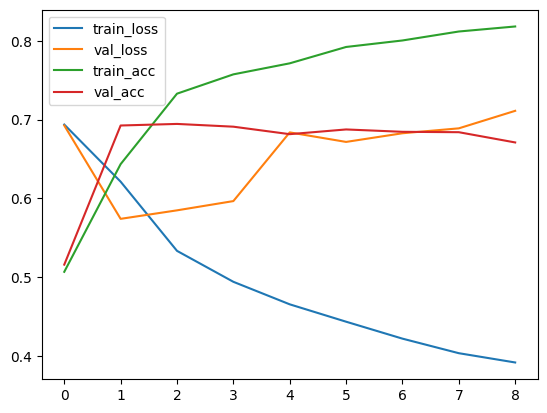

In [25]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_onehot) * 0.8)
val_size = len(train_onehot) - train_size

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

# 학습/검증셋 분할 + 미니배치 사용하도록 DataLoader 생성
train_dataset, val_dataset = random_split(TensorDataset(train_onehot, train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()  # binary cross entropy loss
optimizer = optim.Adam(lstm_model.parameters(), lr=0.05)

# 시각화를 위한 손실값, 정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stop_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  lstm_model.train()
  total_loss, correct, total = 0, 0, 0  # total_loss = 에폭동안 누적손실을 저장해줄 변수 , correct = 정확하게 예측한 샘플 수, total = 전체 샘플 수

  for inputs, targets in train_loader:
    optimizer.zero_grad()               # 가중치 초기화
    outputs = lstm_model(inputs).squeeze()   # 예측값 (차원 축소, 1차원으로) / 순전파

    loss = criterion(outputs, targets)  # 손실 계산

    loss.backward()                     # 역전파
    optimizer.step()                    # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0  # total_loss = 에폭동안 누적손실을 저장해줄 변수 , correct = 정확하게 예측한 샘플 수, total = 전체 샘플 수

  with torch.no_grad(): # 가중치 계산이 필요 없기 때문에 연산을 줄여준다
    for val_inputs, val_targets in val_loader:
      val_outputs = lstm_model(val_inputs).squeeze()   # 예측값 (차원 축소, 1차원으로) / 순전파
      loss = criterion(val_outputs, val_targets)  # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # 조기종료 처리
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      early_stop_counter = 0
    else:
      early_stop_counter += 1
      if early_stop_counter >= early_stop_patience:
        print('Early stopping!!!!')
        break

# 시각화
train_history_df = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})

train_history_df.plot()
plt.show()

In [26]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0  # total_loss = 에폭동안 누적손실을 저장해줄 변수 , correct = 정확하게 예측한 샘플 수, total = 전체 샘플 수

    with torch.no_grad(): # 가중치 계산이 필요 없기 때문에 연산을 줄여준다
      for val_inputs, val_targets in test_loader:
        val_outputs = model(val_inputs).squeeze()   # 예측값 (차원 축소, 1차원으로) / 순전파
        loss = criterion(val_outputs, val_targets)  # 손실 계산
        val_loss += loss.item()

        val_pred = (val_outputs > 0.5).float()
        val_correct += (val_pred == val_targets).sum().item()
        val_total += val_targets.size(0)

    test_loss = val_loss / len(test_loader)
    test_acc = val_correct / val_total
    return test_loss, test_acc

In [27]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(lstm_model, test_loader, criterion)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Test Loss: 0.6478, Test Accuracy: 0.7024


##### Embedding + LSTM

In [39]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)
    _, (hidden, _) = self.lstm(x) # 첫번째 _는 최종출력값 (마지막에 들어가있는 데이터(토큰)의 아웃풋. 이전 정보들만 가지고 오고 싶어서 이렇게 처리를 해줬다)   /  두번째 _는 셀스테이트에 대한 값
    out = self.fc(hidden[-1]) # 최종 출력층을 통과시킴
    return self.sigmoid(out)  # 시그모이드를 통과킨 값을 반환

In [40]:
from pickle import EMPTY_DICT
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50

ebd_lstm_model = SentimentLSTM(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)
print(ebd_lstm_model)

SentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm): LSTM(50, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [41]:
total_params = 0
print(f"{'Layer':<20}{'Shape':30}{'Params'}")
print("=" * 60)

for name, param in ebd_lstm_model.named_parameters():
  if param.requires_grad: # gradient가 필요하다. 즉, 역전파가 일어나는, 업데이트 되는 것들이 맞으면
    param_count = param.numel() # 특성의 총 개수
    total_params += param_count

    print(f"{name:<20}{str(list(param.shape)):30}{param_count}")
print("=" * 60)
print(f'Total Trainable Parameters: {total_params}')    # rnn에 비해 개수가 4배 (왜 늘어났지? 활성화함수가 4배라서) 모델이 스스로 학습해서 뭔가를 할 수 있는 능력이 향상된다

Layer               Shape                         Params
embedding.weight    [300, 50]                     15000
lstm.weight_ih_l0   [32, 50]                      1600
lstm.weight_hh_l0   [32, 8]                       256
lstm.bias_ih_l0     [32]                          32
lstm.bias_hh_l0     [32]                          32
fc.weight           [1, 8]                        8
fc.bias             [1]                           1
Total Trainable Parameters: 16929


Epoch 1/100 | Train Loss: 0.6940, Train Acc: 0.5108, Val Loss: 0.6916, Val Acc: 0.5215
Epoch 2/100 | Train Loss: 0.6814, Train Acc: 0.5614, Val Loss: 0.6853, Val Acc: 0.5725
Epoch 3/100 | Train Loss: 0.6661, Train Acc: 0.5919, Val Loss: 0.6810, Val Acc: 0.5780
Epoch 4/100 | Train Loss: 0.6328, Train Acc: 0.6424, Val Loss: 0.6499, Val Acc: 0.6385
Epoch 5/100 | Train Loss: 0.6067, Train Acc: 0.6715, Val Loss: 0.6510, Val Acc: 0.6425
Epoch 6/100 | Train Loss: 0.5820, Train Acc: 0.7010, Val Loss: 0.6510, Val Acc: 0.6545
Epoch 7/100 | Train Loss: 0.5682, Train Acc: 0.7141, Val Loss: 0.6481, Val Acc: 0.6600
Epoch 8/100 | Train Loss: 0.5533, Train Acc: 0.7238, Val Loss: 0.6466, Val Acc: 0.6680
Epoch 9/100 | Train Loss: 0.5426, Train Acc: 0.7366, Val Loss: 0.6603, Val Acc: 0.6695
Epoch 10/100 | Train Loss: 0.5379, Train Acc: 0.7402, Val Loss: 0.6704, Val Acc: 0.6620
Epoch 11/100 | Train Loss: 0.5252, Train Acc: 0.7472, Val Loss: 0.6597, Val Acc: 0.6565
Epoch 12/100 | Train Loss: 0.5130, Train 

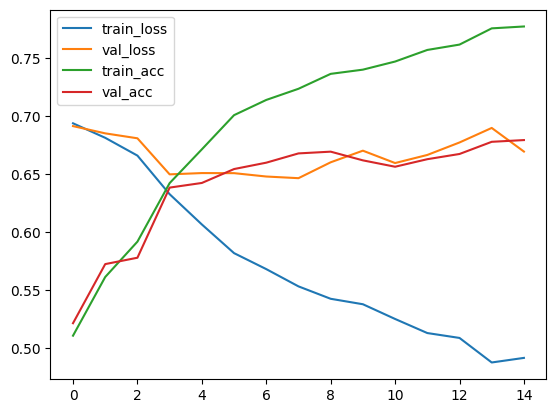

In [42]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_seq) * 0.8)
val_size = len(train_seq) - train_size

# 학습/검증셋 분할 + 미니배치 사용하도록 DataLoader 생성
train_target = train_target.to(torch.float32)
train_dataset, val_dataset = random_split(TensorDataset(train_seq.to(torch.long), train_target), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()  # binary cross entropy loss
optimizer = optim.Adam(ebd_lstm_model.parameters(), lr=0.01)

# 시각화를 위한 손실값, 정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stop_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  ebd_lstm_model.train()
  total_loss, correct, total = 0, 0, 0  # total_loss = 에폭동안 누적손실을 저장해줄 변수 , correct = 정확하게 예측한 샘플 수, total = 전체 샘플 수

  for inputs, targets in train_loader:
    optimizer.zero_grad()               # 가중치 초기화
    outputs = ebd_lstm_model(inputs).squeeze()   # 예측값 (차원 축소, 1차원으로) / 순전파

    loss = criterion(outputs, targets)  # 손실 계산

    loss.backward()                     # 역전파
    optimizer.step()                    # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  ebd_lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0  # total_loss = 에폭동안 누적손실을 저장해줄 변수 , correct = 정확하게 예측한 샘플 수, total = 전체 샘플 수

  with torch.no_grad(): # 가중치 계산이 필요 없기 때문에 연산을 줄여준다
    for val_inputs, val_targets in val_loader:
      val_outputs = ebd_lstm_model(val_inputs).squeeze()   # 예측값 (차원 축소, 1차원으로) / 순전파
      loss = criterion(val_outputs, val_targets)  # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # 조기종료 처리
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      early_stop_counter = 0
    else:
      early_stop_counter += 1
      if early_stop_counter >= early_stop_patience:
        print('Early stopping!!!!')
        break

# 시각화
train_history_df = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})

train_history_df.plot()
plt.show()

In [34]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Test Loss: 0.7108, Test Accuracy: 0.6340


### 입출력 shape
- return_sequences
- return_state
- Bidirectional LSTM/GRU

In [36]:
import numpy as np

B = 2   # batch_size
T = 5   # timestep
D = 10  # embedding_dim
U = 3   # unit(뉴런수)

x = np.random.randn(B, T, D)

##### return_sequences
- LSTM 다층 구조를 만들거나 다대다 구조의 출력이 필요한 시퀀스 예측/변환 작업에서 설정
  - False(기본값) : 마지막 Timestep의 output만 반환
  - True : 모든 Timestep의 output 반환

In [38]:
from tensorflow.keras import models, layers

def lstm(x, return_sequences=False):
  input = layers.Input(shape=(T, D))
  output = layers.LSTM(U, return_sequences=return_sequences)(input)
  model = models.Model(input, output)
  model.summary()
  return model.predict(x)

print(lstm(x, return_sequences=False).shape)
print(lstm(x, return_sequences=True).shape) # 5가 생긴건 timestep

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
(2, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 5, 3)                │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
(2, 5, 3)


##### return_state

- Encoder-Decoder 모델에서 Encoder의 학습된 hidden_state, cell_state를 Decoder의 초기 state값으로 사용 (context vector/thought vector)
  - False(기본값) : LSTM의 output값만 변환
  - True : LSTM output, cell state, hidden state 모두 변환

In [45]:
def lstm2(x, return_state=False):
  input = layers.Input(shape=(T, D))
  output = layers.LSTM(U, return_state=return_state)(input)
  model = models.Model(input, output)
  model.summary()
  return model.predict(x)

print(lstm2(x, return_state=False).shape)
# print(lstm2(x, return_state=True).shape)

output, hidden_state, cell_state = lstm2(x, return_state=True)
print(output.shape, hidden_state.shape, cell_state.shape) # 2 배치사이즈, 3개의 결과  (2, 3)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 3)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
(2, 3)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ [(None, 3), (None, 3),      │             168 │
│                                      │ (None, 3)]                  │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
(2, 3) (2, 3) (2, 3)


##### Bidirectional LSTM

In [47]:
def bi_lstm(x, return_sequences=False, return_state=False):
  input = layers.Input(shape=(T, D))
  lstm = layers.LSTM(U, return_sequences=return_sequences, return_state=return_state) # unit 3개를 양방향으로 돌다보니 unit이 6, 즉(2, 6) shape으로 출력 / (10입력 * 3개 유닛 + 3개 유닛 * 3 + 편향 3) * 활성화함수 4 * 양방향 2 = 336
  output = layers.Bidirectional(lstm)(input)
  model = models.Model(inputs=input, outputs=output)
  model.summary()
  return model.predict(x)

output1 = bi_lstm(x)
print(output1.shape)

output2 = bi_lstm(x, return_sequences=True) # shape에 timestep 5 추가
print(output2.shape)

# output3 = bi_lstm(x, return_state=True) # 5개 반환 / output, hidden state 순방향, hidden state 역방향, cell state 순방향, cell state 역방향  총 5개
output3 , for_h_stt, for_c_stt, back_h_stt, back_c_stt = bi_lstm(x, return_state=True)
print(output3.shape , for_h_stt.shape, for_c_stt.shape, back_h_stt.shape, back_c_stt.shape)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 6)                   │             336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
(2, 6)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 5, 6)                │             336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
(2, 5, 6)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ [(None, 6), (None, 3),      │             336 │
│                                      │ (None, 3), (None, 3),       │                 │
│                                      │ (None, 3)]                  │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
(2, 6) (2, 3) (2, 3) (2, 3) (2, 3)
